#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [ ]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

In [3]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

In [ ]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.15]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### AcO reconstructor+controller settings

In [4]:
n_bm = 27

In [16]:
from scipy.linalg import block_diag

# Reconstructor settings
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)
    
# Compute AcO reconstructor using decoupled strategy
w_M1TxyzRxyz = np.diag(np.array([1,1,1,4,4,4]))
w_M2TxyzRxyz = np.diag(np.array([50,40,40,8,8,8]))          
w_M1BM = 0.01*np.eye(n_bm)
W2 = block_diag(w_M1TxyzRxyz, w_M2TxyzRxyz, w_M1BM)

W2_coeff = 0.01/np.trace(W2)
print('Weighting factor of W2:',W2_coeff)
W2 = W2_coeff*W2
            
#Mceo = dos.tools.build_AcO_Rec(dt['calibdt'][()]['D'],
#                                  n_bm=n_bm, W2=W2, rec_alg='RLS',#TSVD
#                                  wfsMask=dt['calibdt'][()]['wfsMask'])
# MPC settings

# Plant dynamic model matrices
A = np.zeros((84+7*n_bm,84+7*n_bm))
B = np.identity(84+7*n_bm)
nx, nu = A.shape[0], B.shape[1]

# Prediction horizon
npred = 4
# Weighting matrices
Q = (0.2/npred)*sparse.block_diag([1]*nx)
R = (1/npred)*sparse.block_diag([1]*nu)
# Controller output constraints
dumin, dumax = -0.25*np.ones(nu), 0.25*np.ones(nu)
umin, umax = -2*np.ones(nu), 2*np.ones(nu)

# MPC dictionary
data = {'SHAcO':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                       'wfsMask':dt['calibdt'][()]['wfsMask'],
                       'A':A,'B':B,'Q':Q,'R':R,
                       'npred':npred,'dumin':dumin,'dumax':dumax,
                       'umin':umin,'umax':umax}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    
# dictionary for debug
data = {'SHAcO_debug':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                       'wfsMask':dt['calibdt'][()]['wfsMask'],
                       'A':A,'B':B,'Q':Q,'R':R,
                       'npred':npred,'dumin':dumin,'dumax':dumax,
                       'umin':umin,'umax':umax}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO_debug.pickle','wb') as f:
    pickle.dump(data,f)

Weighting factor of W2: 5.9077213918591625e-05


#### Set initial M1/M2 states and generate respective yaml files

In [6]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

#test_case = 's1_curvature_error'
test_case = 'BM_dist'

if 'm1_x0_dt' in locals():
    del m1_x0_dt
if 'm2_x0_dt' in locals():
    del m2_x0_dt    

if(test_case == 's1_curvature_error'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
#        
elif(test_case == 'fully_aligned'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
#        
elif(test_case == 'BM_dist'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m1_x0_dt['state']['modes'][0][1] = 0.0
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
    
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)        

#### Instantiate DOS

In [17]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SH_AcO/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: SHAcO
INFO:SHAcO:New input: wfs48 data
INFO:SHAcO:New output: M1 Txyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M1 Rxyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M2 Txyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M2 Rxyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M1 BM
INFO:SHAcO:Output logged in!
INFO:DOS:New driver: SHAcO_debug
INFO:SHAcO_debug:New input: wfs48 data
INFO:SHAcO_debug:New output: x_hat
INFO:SHAcO_debug:Output logged in!
INFO:DOS:New driver: science
INFO:science:No inputs!
INFO:science:New output: wfe_rms
INFO:science:Output l

SIMCEO server received: Acknowledging connection from SIMCEO client!
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
27 BMs used in the reconstructor computation.


INFO:DOS:Simulation setup for a duration of 35s @ 1Hz (35 steps)!


No reconstructor matrix row reordering!
Dimension of Dsh: (7360, 273)


In [18]:
# Start simulation
#sim.start()
sim._run_()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP2
INFO:science:OP3
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None
INFO:DOS:Running


27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
9.145652942002926e-12 6.458464225674106e-13 14.16072400873033
9.243154579259544e-12 7.495840786172766e-13 12.331044432413728
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
1.047800457235117e-12 3.170776880641018e-13 3.3045543621577345
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
2.880740931255967e-13 2.524491706713885e-13 1.1411172092958901
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
1.6234368531748186e-13 2.310619704408293e-13 0.7025980303368661
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
1.1082934482579114e-13 2.1646040680390077e-13 0.5120074680733434
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
7.759083455209756e-14 2.0447024846700668e-13 0.37947249115128656
27 BMs used in the reconstructor comput

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 65.88347387313843


In [6]:
sim.pctComplete

100

In [42]:
sim.push()

INFO:DOS:Pushing configuration to server


In [6]:
sim.init()

INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None


In [67]:
sim.terminate()

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


In [104]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 13 entries:
  * wfs48
    1. M12_RBM: (273,)x30
  * ReconstructorM
    1. x_hat: (273,)x30
  * AcO_controller
    1. M1 Txyz: (7, 3)x30
    2. M1 Rxyz: (7, 3)x30
    3. M2 Txyz: (7, 3)x30
    4. M2 Rxyz: (7, 3)x30
    5. M1 BM: (7, 27)x30
  * science
    1. wfe_rms: (1,)x30
    2. segment_wfe_rms: (7,)x30
    3. PSSn: (1,)x30
    4. tiptilt: (2,)x30
    5. segment_piston: (7,)x30
    6. segment_tiptilt: (14,)x30)

In [9]:
sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]

array([5.59843193e-06, 7.71736230e-10, 7.71736453e-10, 7.71906428e-10,
       7.71736397e-10, 7.71736175e-10, 1.72432388e-10])


Final values:
 WFE: [118.16942447] 
 [5.74445425 0.7716553  0.77171752 0.77208362 0.77220119 0.77268425
 0.17243268] 
PSSn: [0.99999807] 
sum of abs seg piston: 0.3373056928004936 
 [ 3.35289201e-01 -8.18711973e-05 -1.60973165e-04  1.55069041e-04
 -8.32561853e-04  3.15203530e-04  4.70813166e-04]



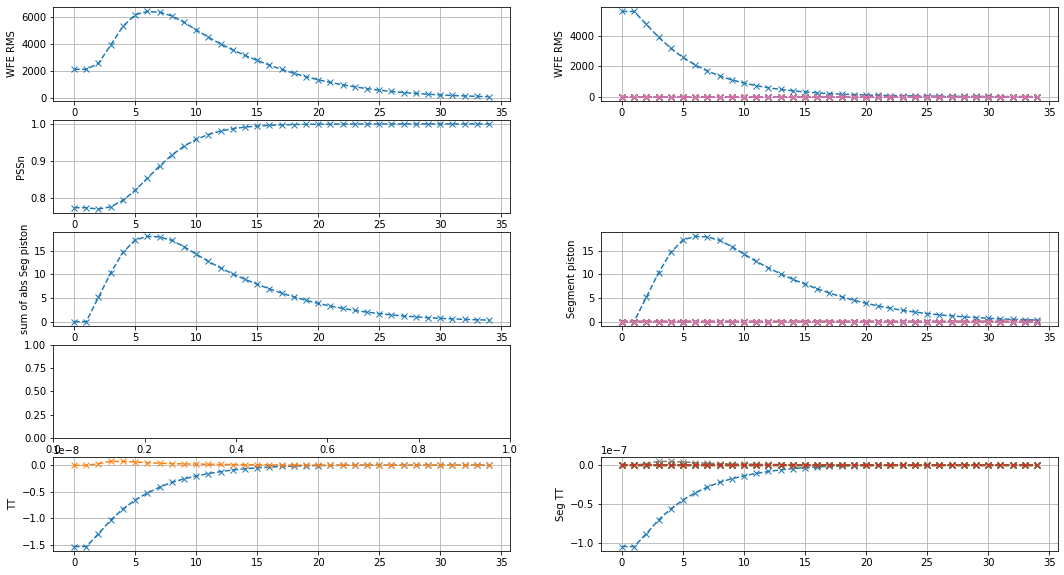

In [10]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE: [39.7460127] 
 [5.81128257 0.77163659 0.7719021  0.77198659 0.77190743 0.77180873
 0.17243537] 
PSSn: [0.99999808] 
sum of abs seg piston: 0.11438967365343111 
 [ 1.12529939e-01 -9.79688899e-06 -3.53167384e-04  1.00784006e-04
 -7.77241993e-04  1.48396809e-04  4.70347428e-04]



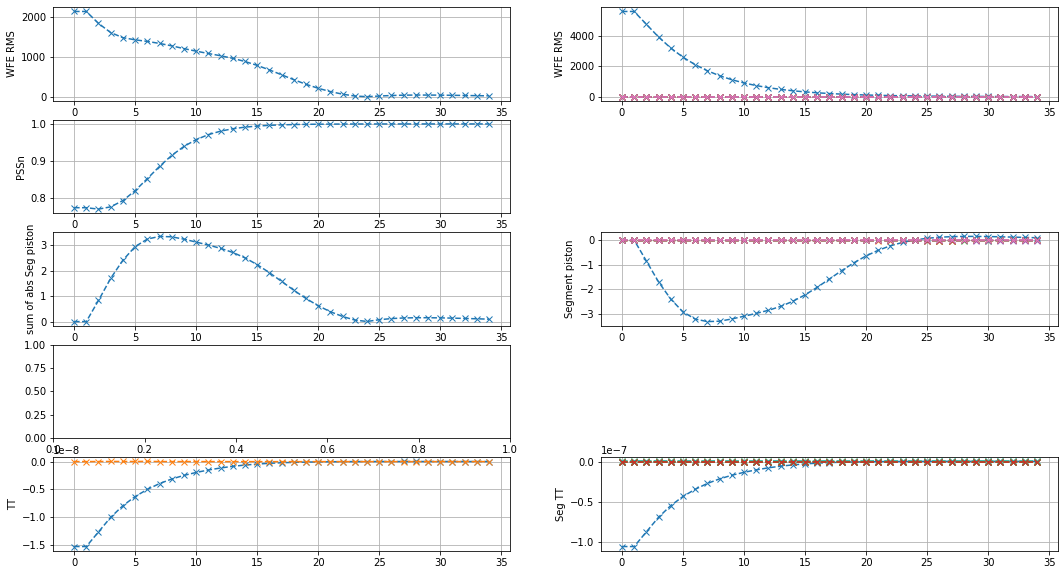

In [19]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

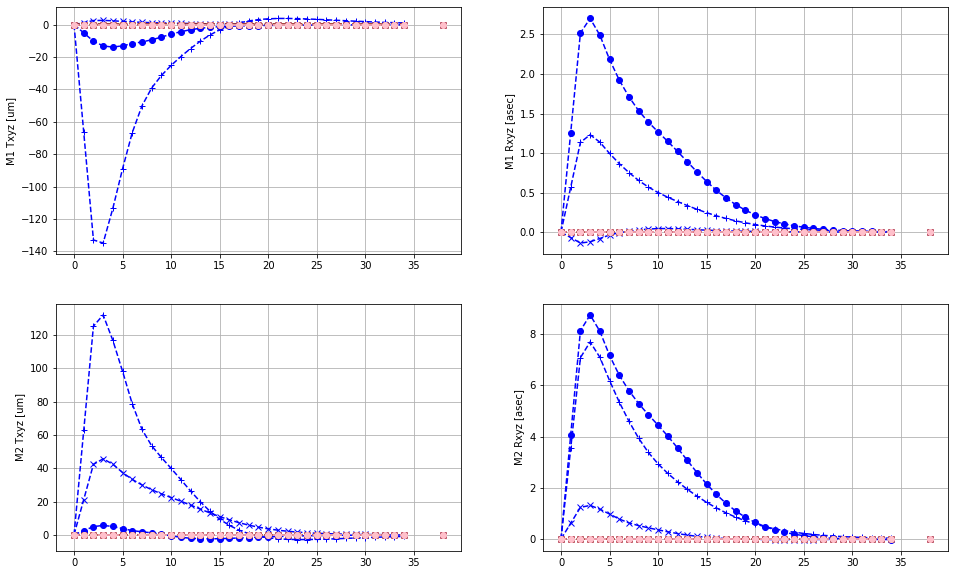

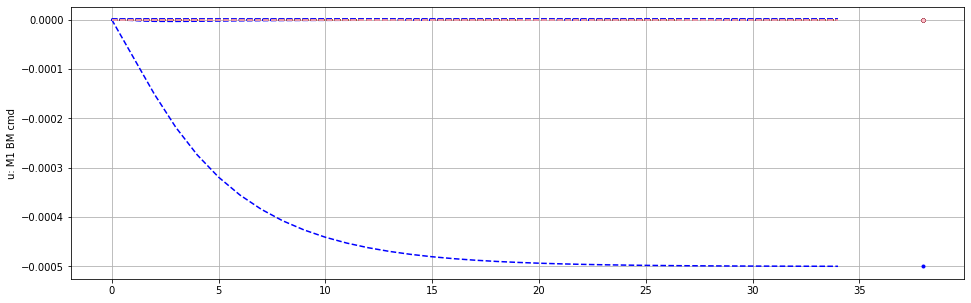

In [11]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

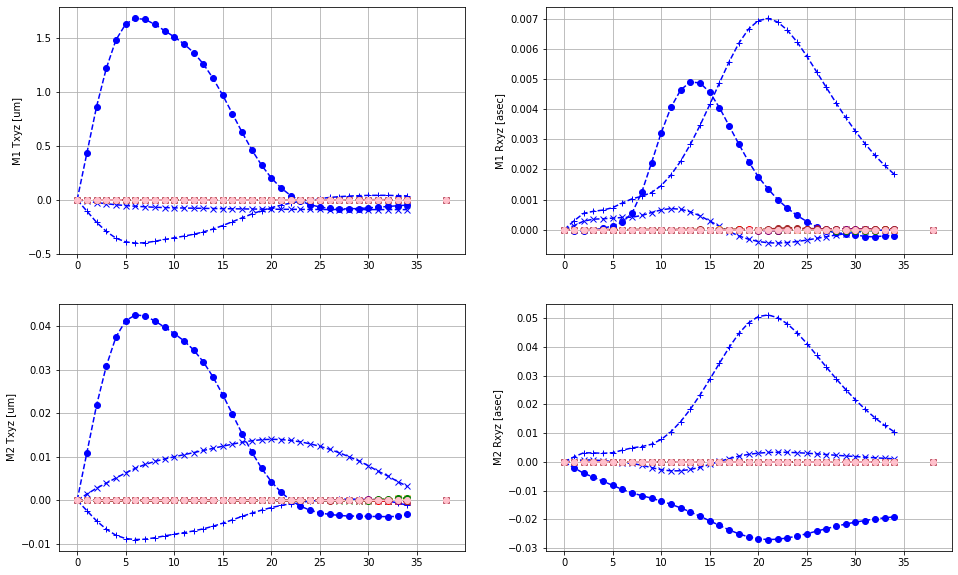

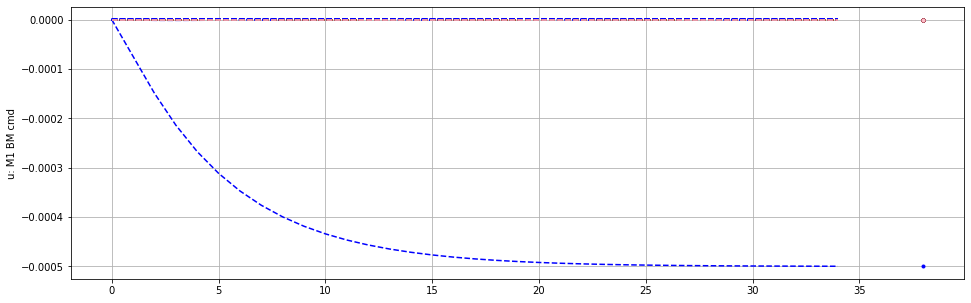

In [20]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [12]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

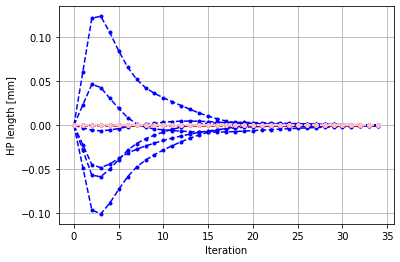

In [14]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

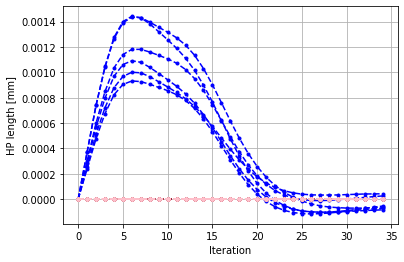

In [21]:
sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

#### Reconstructed states

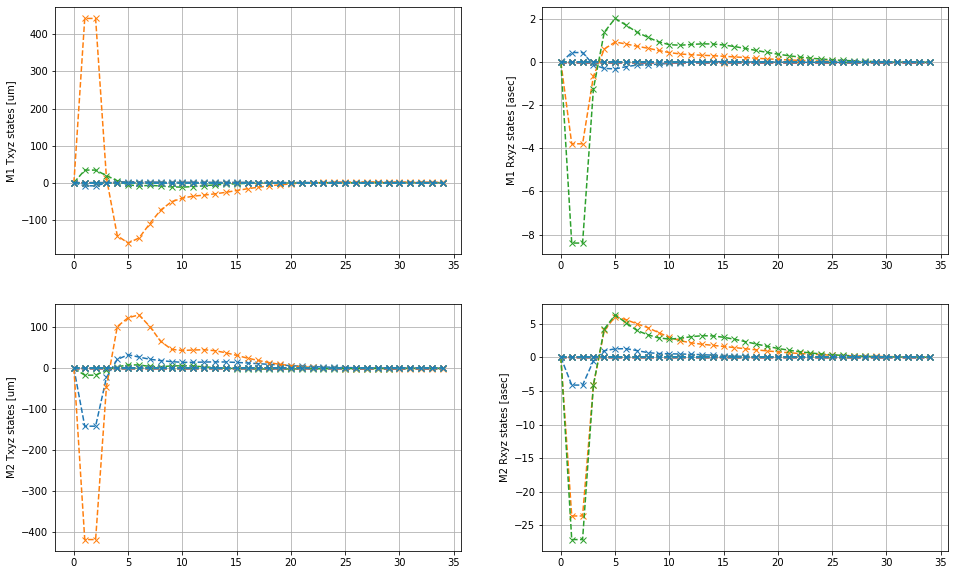

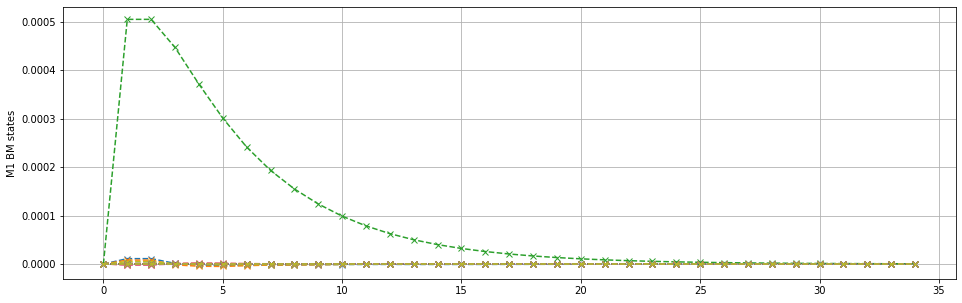

In [15]:
ptools.plot_states(sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries, n_bm)

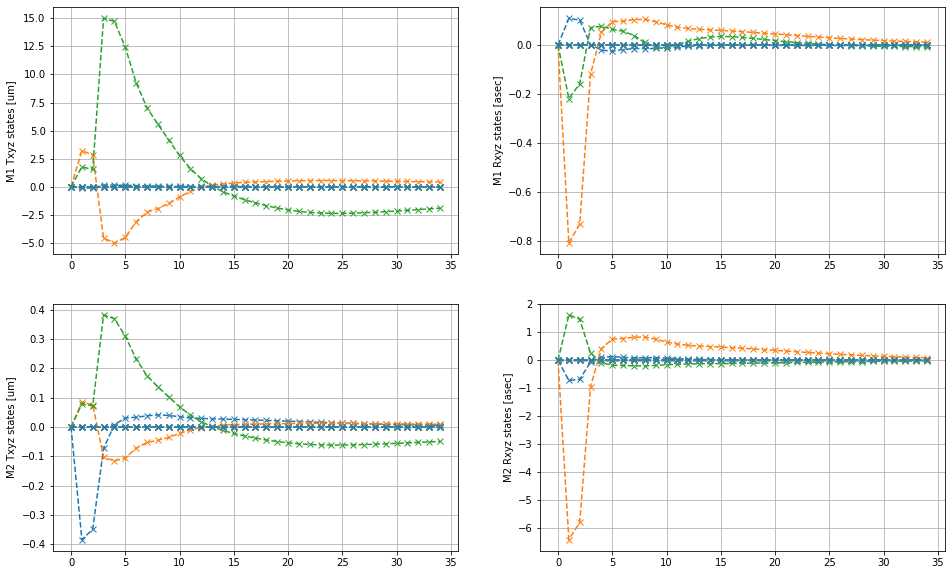

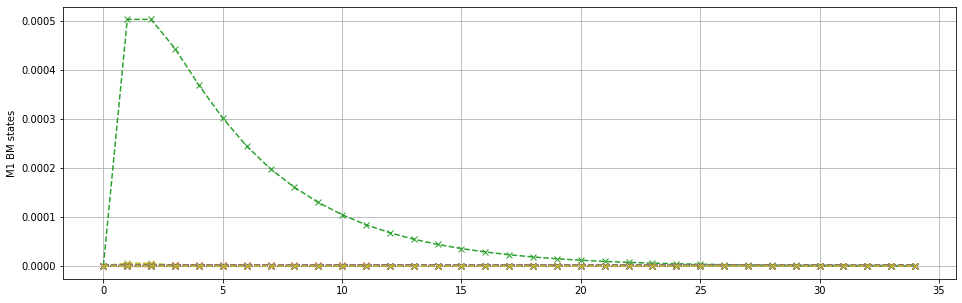

In [22]:
ptools.plot_states(sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries, n_bm)